# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* So physics constraints are needed near shock waves. They are conservation laws, Rankine-Hugoniot relations and entropy condition. We develop a physics screen method here to determinate the problem.


In [1]:
from PINNs import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
dtype=torch.float64
setup_seed(2)
Ts = 0
Te = 0.1
Xs = 0
Xe = 1
Nx = 100
Nt = 100

In [30]:

setup_seed(7)
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        #loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        #loss_rh1 = model.loss_rh(x_screen2,x_screen2_L,x_screen2_R) # RH relation
        #loss_s0 = model.loss_character(x_screen2,x_screen2_R) # Entropy condition
        #loss_con3 = model.loss_con(x_screen3 ,x_ic,T3) #Conservation laws
        #loss_con1 = model.loss_con(x_screen1 ,x_ic,T1) #Conservation laws
        loss = loss_pde + 10*(loss_ic)# +loss_bc) +  10*(loss_rh1)  +10* loss_s0 +10*loss_con3   +10* loss_s0  
        #print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_rh1:{loss_rh1:.8f},loss_con:{loss_con1:.8f}, loss_s:{loss_s0:.8f}, loss_ic:{loss_ic:.8f}')
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

x_ic,x_bc,x_int =  Mesh_Data(Nx,Nt,Ts,Te,Xs,Xe)

xlimits = np.array([[0.,0],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic= sampling(100)
rho_ic, u_ic, p_ic= IC_123(x_ic)                    
xlimits = np.array([[0.,Te],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_int= sampling(10000)
#xlimits = np.array([[0.,Te],[0.4, 0.6]])  #interal
#sampling = LHS(xlimits=xlimits)
#x_int_add= sampling(1000)
#x_int = np.append(x_int,x_int_add,axis=0)
#xlimits = np.array([[0.,Te],[0.45, 0.55]])  #interal
#sampling = LHS(xlimits=xlimits)
#x_int_add= sampling(1000)
#x_int = np.append(x_int,x_int_add,axis=0)
x_ic = torch.tensor(x_ic,requires_grad=True, dtype=dtype).to(cuda)
x_int = torch.tensor(x_int, requires_grad=True, dtype=dtype).to(cuda)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(cuda)
u_ic = torch.tensor(u_ic, dtype=dtype).to(cuda)
p_ic = torch.tensor(p_ic, dtype=dtype).to(cuda)




In [23]:
model = PINNs_Euler_1D(Nl=6,Nn=60).to(cuda).double()
print('Start training...')
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
loss_history=[]
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.05:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')

optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)

epochi = 0

epochs = 5000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    #loss_history.append(to_numpy(loss))
    #if loss < 0.01:
    #    break
toc = time.time()

print(f'Total training time: {toc - tic}')

Start training...
epoch 1 loss_pde:0.00325876, loss_ic:5.29286304
loss_tot:52.93188912
epoch 2 loss_pde:0.00317114, loss_ic:5.13370204
loss_tot:51.34019159
epoch 3 loss_pde:0.00331565, loss_ic:4.98939909
loss_tot:49.89730659
epoch 4 loss_pde:0.00372682, loss_ic:4.85196710
loss_tot:48.52339781
epoch 5 loss_pde:0.00457573, loss_ic:4.71657245
loss_tot:47.17030026
epoch 6 loss_pde:0.00617348, loss_ic:4.58048013
loss_tot:45.81097480
epoch 7 loss_pde:0.00906380, loss_ic:4.44267032
loss_tot:44.43576702
epoch 8 loss_pde:0.01419015, loss_ic:4.30388754
loss_tot:43.05306552
epoch 9 loss_pde:0.02315150, loss_ic:4.16682025
loss_tot:41.69135403
epoch 10 loss_pde:0.03857909, loss_ic:4.03619076
loss_tot:40.40048670
epoch 11 loss_pde:0.06463655, loss_ic:3.91851197
loss_tot:39.24975625
epoch 12 loss_pde:0.10756264, loss_ic:3.82112727
loss_tot:38.31883535
epoch 13 loss_pde:0.17582787, loss_ic:3.74992727
loss_tot:37.67510053
epoch 14 loss_pde:0.27898798, loss_ic:3.70533598
loss_tot:37.33234777
epoch 15 lo

In [37]:
#model.load_state_dict(torch.load(PATH))
torch.save(model.to(cpu),'123_ori.pth')
#model = torch.save('backcorner.pt')


In [19]:
model_path = '123.pth'
model = torch.load(model_path, map_location=cpu)
model = model.to(cuda)

In [ ]:
plt.plot(loss_history)

In [31]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.2,max_iter=30)
epochi = 0
epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    #loss_history.append(to_numpy(loss))
    #if loss < 0.01:
    #    break
toc = time.time()

print(f'Total training time: {toc - tic}')

epoch 0 loss_pde:5.17822557, loss_ic:0.00000161
epoch 0 loss_pde:0.15243311, loss_ic:0.00315604
epoch 0 loss_pde:0.14494489, loss_ic:0.00314868
epoch 0 loss_pde:0.11747666, loss_ic:0.00313398
epoch 0 loss_pde:0.09959759, loss_ic:0.00313761
epoch 0 loss_pde:0.08729409, loss_ic:0.00315378
epoch 0 loss_pde:0.07846924, loss_ic:0.00317597
epoch 0 loss_pde:0.07195860, loss_ic:0.00320370
epoch 0 loss_pde:0.06700970, loss_ic:0.00323647
epoch 0 loss_pde:0.06311438, loss_ic:0.00327431
epoch 0 loss_pde:0.05992462, loss_ic:0.00331746
epoch 0 loss_pde:0.05719725, loss_ic:0.00336645
epoch 0 loss_pde:0.05475864, loss_ic:0.00342213
epoch 0 loss_pde:0.05248162, loss_ic:0.00348559
epoch 0 loss_pde:0.05027134, loss_ic:0.00355814
epoch 0 loss_pde:0.04805770, loss_ic:0.00364109
epoch 0 loss_pde:0.04579356, loss_ic:0.00373535
epoch 0 loss_pde:0.04345643, loss_ic:0.00384077
epoch 0 loss_pde:0.04105109, loss_ic:0.00395529
epoch 0 loss_pde:0.03859842, loss_ic:0.00407535
epoch 0 loss_pde:0.03619013, loss_ic:0.0

In [34]:
x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(0.1,  0.1, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(cuda)
u_pred = model(x_test)
rho, p,u = u_pred[:, 0], u_pred[:, 1], u_pred[:, 2]          
U2 = rho*u
U3 = 0.5*rho*u**2 + p/0.4

#F1 = U2
F2 = rho*u**2+p
F3 = u*(U3 + p)

gamma = 1.4                                                    

# Gradients and partial derivatives
drho_g = gradients(rho, x_test)[0]                                  
rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


du_g = gradients(u, x_test)[0]                                      
u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                      
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                     
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           

dU2_g = gradients(U2, x_test)[0]
U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
dU3_g = gradients(U3, x_test)[0]
U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
dF2_g = gradients(F2, x_test)[0]
F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
dF3_g = gradients(F3, x_test)[0]
F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

d = 0.1*(abs(u_x)-(u_x))  + 1

#d = 0.1*(abs(uR-uL)-(uR-uL))/Dx + 1
#d = torch.exp(-10*u_x)+1
#d1 = torch.clamp(d/5,min=1)

f = ((rho_t + U2_x)/d)**2 + \
    ((U2_t  + F2_x)/d)**2 + \
    ((U3_t  + F3_x)/d)**2 #+\
#d = 1/(0.1*(torch.clamp((abs(u_x)-u_x))
d = 1/(0.1*(abs(u_x)-u_x)+1)
d = to_numpy(d)
f = to_numpy(f)
#d3 = to_numpy(d3)
u_pred = to_numpy(u_pred)
np.size(u_pred[:,0])

100

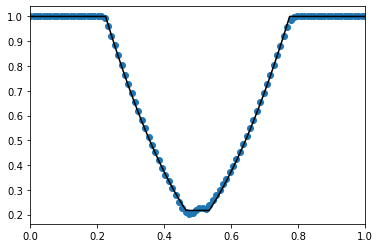

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#ax.scatter(x[:],u_pred[:,0])
#ax.scatter(x[:],u_pred[:,1])
#ax.scatter(x[:],u_pred[:,2])
ax.scatter(x[:],u_pred[:,1]/u_pred[:,0]/0.4)
#ax.scatter(x[:],d)
#ax.scatter(x[:],f)
#ax.plot(Exact[:,0],Exact[:,1],color='black')
#ax.plot(Exact[:,0],Exact[:,2],color='black')
#ax.plot(Exact[:,0],Exact[:,3],color='black')
ax.plot(Exact[:,0],Exact[:,4]/0.4,color='black')
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(-1.0, 1.0)
plt.savefig('1.eps', format='eps')
#ax.set_ylim(0.0, 1.2)
plt.show()

In [7]:
np.min(Exact[:,3])

NameError: name 'Exact' is not defined

In [ ]:
u_pred_i[:,:,k] = u_pred
k = k+1

In [ ]:

u_pred_i = np.zeros((100,3,10))
k = 0

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [17]:
Exact = np.loadtxt('123e.dat')
Exact[:,0]

array([-0.0496663 , -0.04829213, -0.04691796, ...,  1.0455438 ,
        1.04691796,  1.04829213])

In [ ]:
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
#ax.plot(x,np.max([0.1-x,np.zeros_like(x)],axis=0))
#ax.plot(x,np.exp(100*(0.1-x))/ np.exp(100*(0.1)))
#ax.plot(x,np.exp(100*(-x)))
ax.plot(x,np.exp(100*(x-0.1)))
plt.show()

In [ ]:
np.max([0.1-x,np.zeros_like(x)],axis=0)

In [39]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
ee= (u_pred[:,1]/u_pred[:,0]/0.4).flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp,ee))    
np.savetxt('123_PINNs.dat', uxy)

In [ ]:
xp= Exact[:,0].flatten()[:,None]
rhop= Exact[:,1].flatten()[:,None]
up= Exact[:,2].flatten()[:,None]
pp= Exact[:,3].flatten()[:,None]
ee= (Exact[:,4]/0.4).flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp,ee))    
np.savetxt('123exact.dat', uxy)


In [ ]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [ ]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()